In [1]:
# Geometry, shapefiles and projections
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import pyproj
from numpy import inf
import pickle
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import geopandas as gpd

In [2]:
# File containing lat lon points
df = pd.read_csv('../data/df_geo_results.csv')
df.reset_index(inplace=True, drop=True)

# Read SHP data
shp_filename = '../data/raw/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom.shp'
shapes = gpd.GeoDataFrame.from_file(shp_filename)
shapes.crs = {"init": "epsg:27700"}

In [3]:
def check_lat_lon(row):
    """Returns false if the row has null lat or lng values"""
    return True if not pd.isnull(row.lat) or not pd.isnull(row.lng) else False

In [4]:
df["geometry"] = df.apply(lambda row: Point(row["lng"], row["lat"]) 
                                        if check_lat_lon(row) else None, axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry")
df.crs = {"init": "epsg:27700"}

In [5]:
df[['Participant Name', 'geometry']].head()

,Participant Name,geometry
0,De Montfort University,POINT (-1.1380354 52.62946729999999)
1,University of Bradford,POINT (-1.7621302 53.79170139999999)
2,Defence Science & Tech Lab DSTL,POINT (-1.7088344 51.1297285)
3,Defence Science & Tech Lab DSTL,POINT (-1.7088344 51.1297285)
4,Defence Science & Tech Lab DSTL,POINT (-1.7088344 51.1297285)


In [6]:
# # Generate a function to create a UK East/North point from Lon/Lat
wgs84 = pyproj.Proj(init = 'epsg:4326')
ukgrid = pyproj.Proj(init = 'epsg:27700')
EnPoint = lambda lng, lat : Point(*pyproj.transform(wgs84, ukgrid, lng, lat))
# dummy_point = EnPoint(-1.51,52.41)

In [7]:
df['geometry'] = [EnPoint(df.loc[i, 'lng'], df.loc[i, 'lat']) for i in range(df.shape[0])]

In [8]:
# Perform the spatial join
df = gpd.tools.sjoin(shapes, df, how="right")

In [10]:
df.shape

(475, 17)

## Visualisations 

In [26]:
df['funds'] = df['Grant Offered (£)'].apply(lambda x: float(str(x).split(',')[0]))
df['funds'] = [df.iloc[i, -1] * 0.89 if df.iloc[i, -6] == 'H2020' else df.iloc[i, -1] for i in range(df.shape[0])]

In [30]:
total_funding = df.groupby(['objectid', 'ttwa11nm']).sum()['funds']

In [33]:
participants = {}
for ttwa in set(df.ttwa11nm):
    participants[ttwa] = df[df.ttwa11nm == ttwa].drop_duplicates('project_id').shape[0]
    
participants = pd.DataFrame.from_dict(participants, orient='index')
participants.rename(inplace=True, index=str, columns={0:'Projects'})

/Users/kstathou/anaconda/envs/geo/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


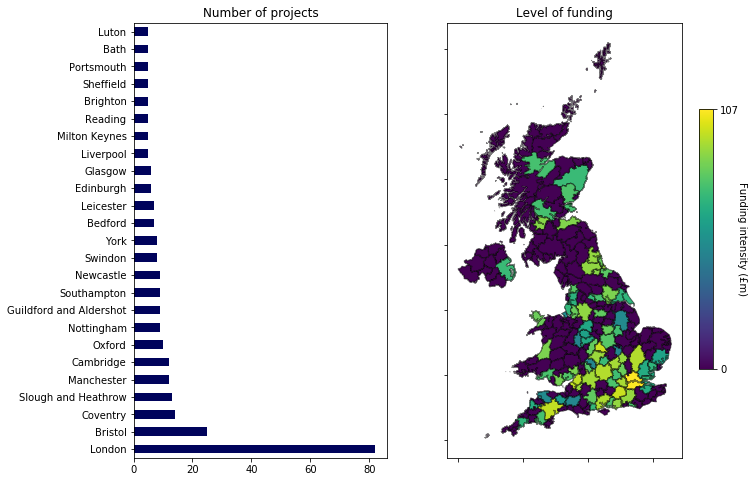

In [34]:
patches = []
color = []

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8)) 

participants.sort_values('Projects', ascending=False).iloc[:25].plot(kind='barh', ax=ax1, color='xkcd:dark blue', legend=False)
ax1.set_title('Number of projects', fontsize=12)

for i in shapes.index:
    patches.append(PolygonPatch(shapes.loc[i, 'geometry'], alpha=0.5, zorder=4))
    try:
        color.append(total_funding.loc[i+1].values[0])
    except KeyError as e:
        color.append(0)

scaled_color = np.log(color)
scaled_color[scaled_color == -inf] = 0
p = PatchCollection(patches, cmap=plt.cm.viridis, match_original=True)
p.set_array(scaled_color)
ax2.add_collection(p)
ax2.set_title('Level of funding', fontsize=12)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# ax2.axis('off')
# ax2.set_axis_off()
ax2.axis('scaled')

cax = fig.add_axes([0.91, 0.28, 0.02, 0.45])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['0', '107']) 

cb.set_label("Funding intensity (£m)", labelpad=8, rotation=270)

fig.savefig('../reports/figures/ttwa_project_count_and_map.png')

plt.show()